In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox

from statsmodels.tsa.stattools import adfuller

In [ ]:
# Load dataset (example: macroeconomic data)
url = "https://raw.githubusercontent.com/selva86/datasets/master/Raotbl6.csv"
data = pd.read_csv(url, index_col='date')

In [2]:
data.head()

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1959-01-01,1606.4,1608.3,47.5,36.9,37.4,26.9,32.3,23.1
1959-04-01,1637.0,1622.2,47.5,37.4,37.5,27.0,32.2,23.4
1959-07-01,1629.5,1636.2,48.7,37.6,37.6,27.1,32.4,23.4
1959-10-01,1643.4,1650.3,48.8,37.7,37.8,27.1,32.5,23.8
1960-01-01,1671.6,1664.6,49.1,37.8,37.8,27.2,32.4,23.8


In [3]:
# time series dataset with macroeconomic variables.
# date: Time period (quarterly data from 1959).
# rgnp: Real Gross National Product.
# pgnp: Predicted Gross National Product.
# ulc: Unit Labor Cost.
# gdfco: Gross Domestic Fixed Capital Formation.
# gdf: Gross Domestic Factor Cost.
# gdfim: Gross Domestic Investment.
# gdfcf: Gross Domestic Capital Formation.
# gdfce: Gross Domestic Final Consumption Expenditure.

In [4]:
# Select relevant variables which needs to be focused onn
df = data[['rgnp', 'ulc', 'gdf']]
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')  

In [5]:
df.head()

,rgnp,ulc,gdf
date,,,
1959-01-01,1606.4,47.5,37.4
1959-04-01,1637.0,47.5,37.5
1959-07-01,1629.5,48.7,37.6
1959-10-01,1643.4,48.8,37.8
1960-01-01,1671.6,49.1,37.8


# Lets check the statoinary

In [7]:
# Check for stationarity
def adf_test(series):
    result = adfuller(series)
    return result[1]  # p-value

In [10]:
a = adf_test(df['rgnp'])
b = adf_test(df['ulc'])
c = adf_test(df['gdf'])

print(a,b,c)

0.9886037114305949 0.997099172882968 0.9953249001658119


Not stationary since the value is greater then 0.05 

In [11]:
# Differencing 
df_diff = df.diff().dropna()  # First-order differencing

In [13]:
x = adf_test(df_diff['rgnp'])
y = adf_test(df_diff['ulc'])
z = adf_test(df_diff['gdf'])

print(x,y,z)

2.9633019848469267e-06 0.006235131830238172 0.5823703618159312


In [14]:
# Differencing 
df_diff2 = df.diff().diff().dropna()  # Second-order differencing

In [17]:
n = adf_test(df_diff2['gdf'])

print(n)

0.00039702611077688097


Series is now stationary 

Generally model does not require it. It does everything on its own

Stationary is just a assumption of VAR model

# Modelling

In [18]:
# Select optimal lag length
model = VAR(df)
lag_selection = model.select_order(maxlags=10)
optimal_lag = lag_selection.aic  # Using AIC-selected lag

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [19]:
print(lag_selection.summary()) 

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        19.76       19.83   3.819e+08       19.79
1        3.105       3.395       22.31       3.223
2        2.539      3.046*       12.68      2.745*
3        2.505       3.229       12.27       2.799
4       2.428*       3.369      11.37*       2.810
5        2.433       3.591       11.46       2.903
6        2.430       3.805       11.47       2.988
7        2.442       4.035       11.67       3.088
8        2.505       4.315       12.52       3.239
9        2.446       4.474       11.92       3.269
10       2.493       4.738       12.64       3.404
--------------------------------------------------


In [20]:
print(optimal_lag)

4


In [21]:
# Fit VAR model
var_model = VAR(df)
results = var_model.fit(optimal_lag)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, Mar, 2025
Time:                     12:21:54
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    3.20391
Nobs:                     119.000    HQIC:                   2.66295
Log likelihood:          -604.001    FPE:                    9.93169
AIC:                      2.29310    Det(Omega_mle):         7.27683
--------------------------------------------------------------------
Results for equation rgnp
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const          -1.971501        18.061171           -0.109           0.913
L1.rgnp         1.058446         0.120276            8.800           0.000
L1.ulc         -2.737284         3.999672           -0.684           0.494
L1.gdf    

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


### After fitting, ensure that the residuals (errors) are uncorrelated and normally distributed

In [24]:
# Check for autocorrelation in residuals (Ljung-Box test)
# Null = residuals are normal which is what we want 
for col in results.resid.columns:
    print(f"\nLjung-Box Test for {col}:")
    lb_test = acorr_ljungbox(results.resid[col], lags=[10], return_df=True)
    print(lb_test)



Ljung-Box Test for rgnp:
     lb_stat  lb_pvalue
10  5.702994   0.839569

Ljung-Box Test for ulc:
     lb_stat  lb_pvalue
10  7.372204   0.689901

Ljung-Box Test for gdf:
     lb_stat  lb_pvalue
10  6.747543   0.749044


# f p-value > 0.05, residuals are white noise (good model fit)

In [25]:
# Forecast next 5 periods
forecast_steps = 5
forecast_values = results.forecast(df.values[-optimal_lag:], steps=forecast_steps)

# Convert to DataFrame
forecast_df = pd.DataFrame(forecast_values, columns=df.columns)
print(forecast_df)

          rgnp         ulc         gdf
0  4166.959372  189.313153  131.370846
1  4190.868576  191.242227  132.568128
2  4216.788958  192.456089  133.682473
3  4245.458366  193.698987  134.751848
4  4271.984938  195.080479  135.852568


/var/folders/8h/xtp_v7md6bs9195xxzbbf5d80000gn/T/ipykernel_2613/2310576326.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  plt.plot(pd.date_range(df.index[-1], periods=forecast_steps, freq='Y'), forecast_df[col], linestyle='dashed', label=f'Forecast {col}')


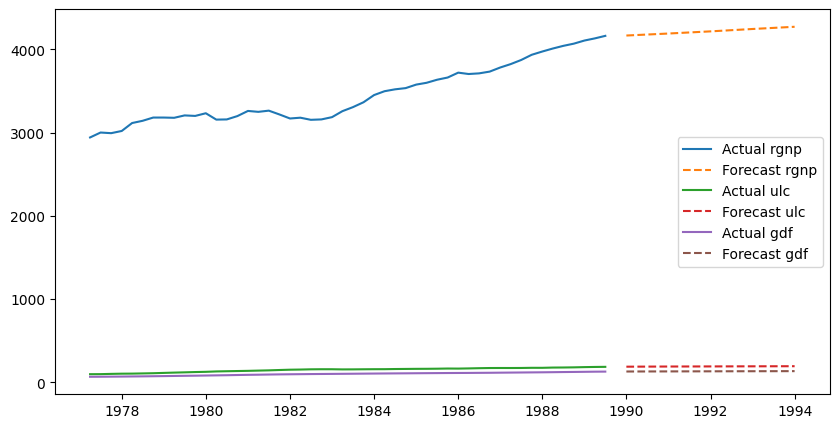

In [26]:
plt.figure(figsize=(10, 5))
for col in df.columns:
    plt.plot(df.index[-50:], df[col].iloc[-50:], label=f'Actual {col}')
    plt.plot(pd.date_range(df.index[-1], periods=forecast_steps, freq='Y'), forecast_df[col], linestyle='dashed', label=f'Forecast {col}')
plt.legend()
plt.show()